[INFO] Using device: cuda

 Running replicate 0
[INFO] Data saved for rep 0
[INFO] rep=0, best_penalty=0.5
[RESULT] rep=0 | Detected CPs=[51, 101, 151] | Covering=1.0000

 Running replicate 1
[INFO] Data saved for rep 1
[INFO] rep=1, best_penalty=10
[RESULT] rep=1 | Detected CPs=[51, 101, 151] | Covering=1.0000

 Running replicate 2
[INFO] Data saved for rep 2
[INFO] rep=2, best_penalty=1
[RESULT] rep=2 | Detected CPs=[51, 101, 151] | Covering=1.0000

 Running replicate 3
[INFO] Data saved for rep 3
[INFO] rep=3, best_penalty=10
[RESULT] rep=3 | Detected CPs=[51, 101, 151] | Covering=1.0000

 Running replicate 4
[INFO] Data saved for rep 4
[INFO] rep=4, best_penalty=0.5
[RESULT] rep=4 | Detected CPs=[51, 101, 151] | Covering=1.0000

 Running replicate 5
[INFO] Data saved for rep 5
[INFO] rep=5, best_penalty=1
[RESULT] rep=5 | Detected CPs=[51, 101, 151] | Covering=1.0000

 Running replicate 6
[INFO] Data saved for rep 6
[INFO] rep=6, best_penalty=10
[RESULT] rep=6 | Detected CPs=[51, 1

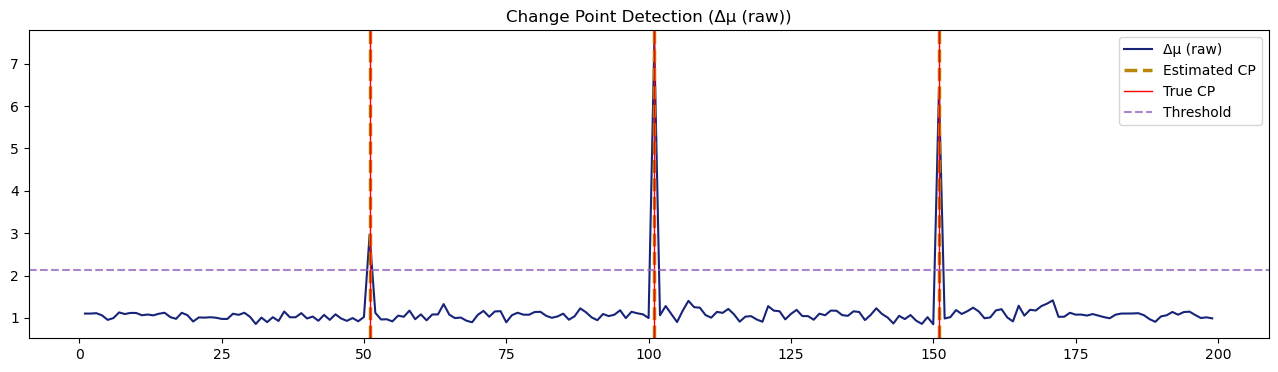

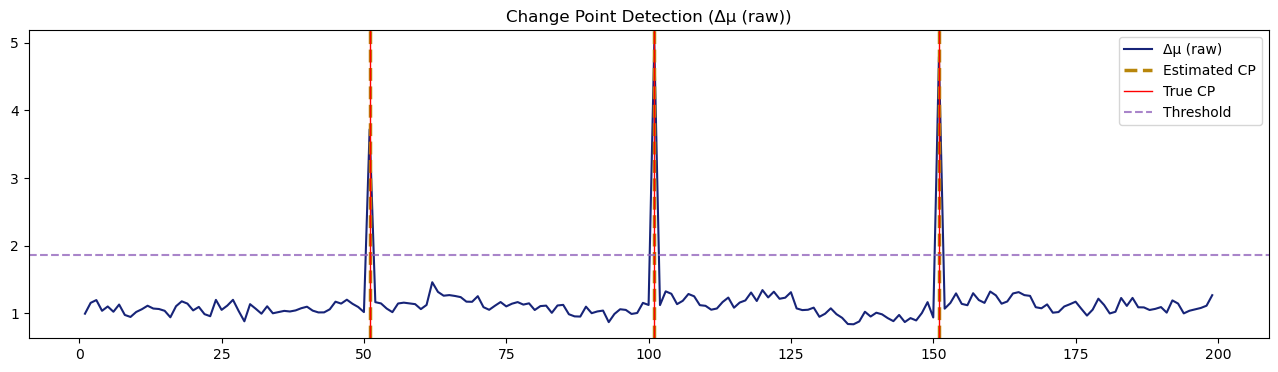

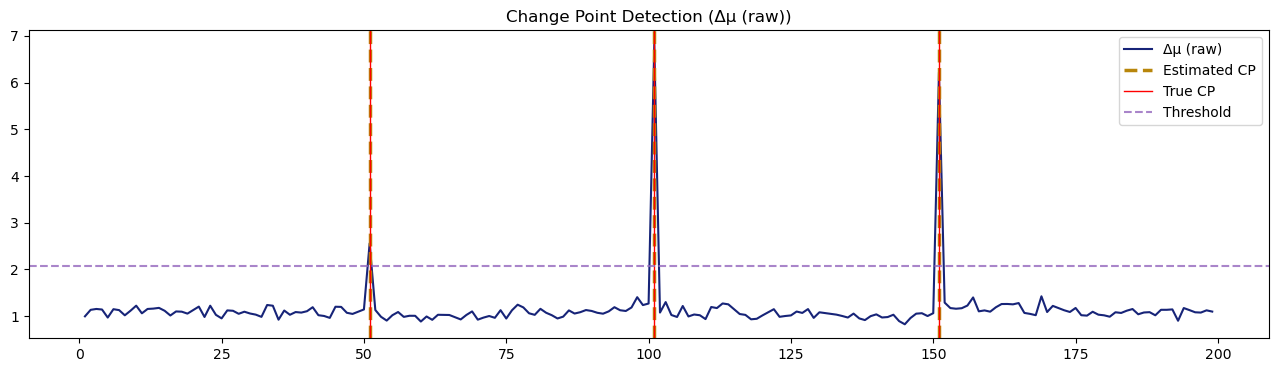

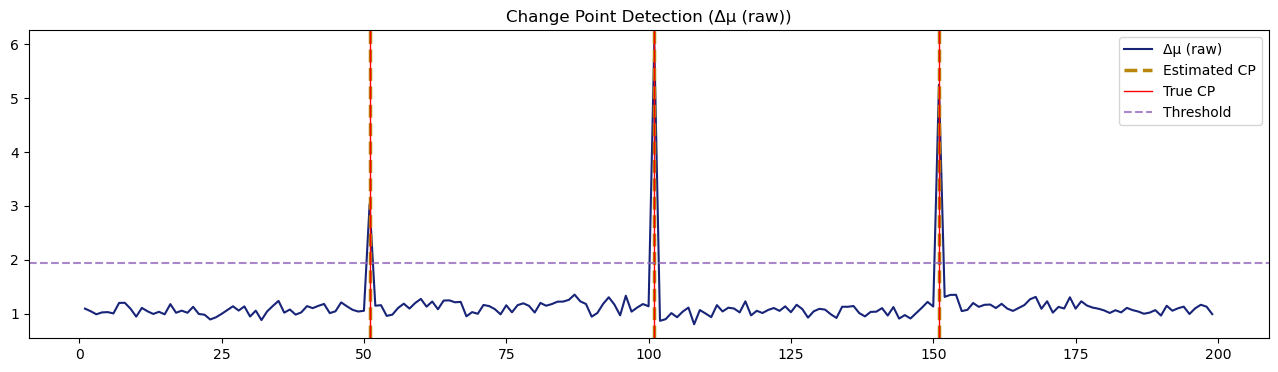

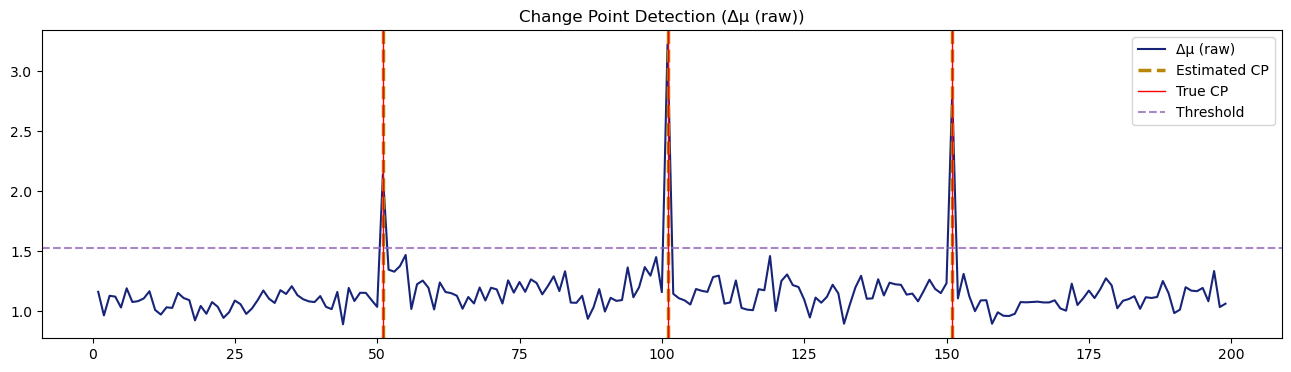

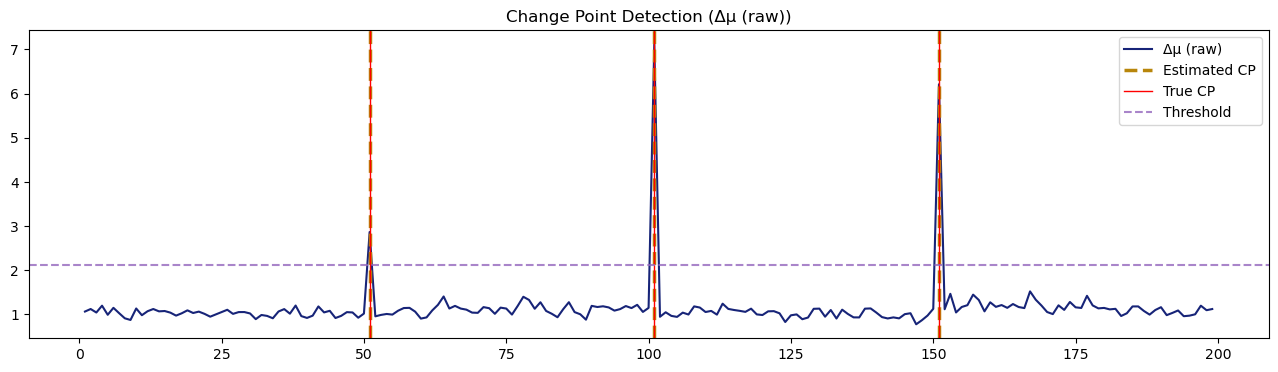

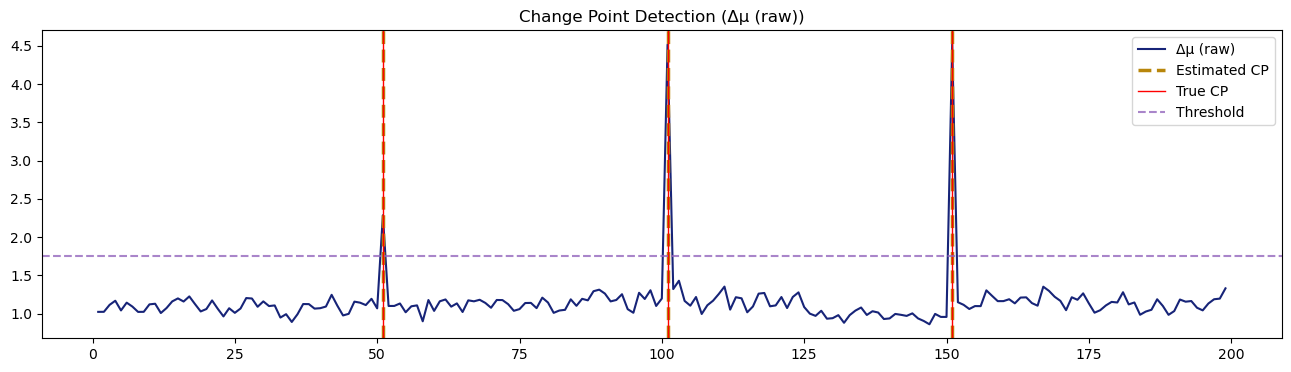

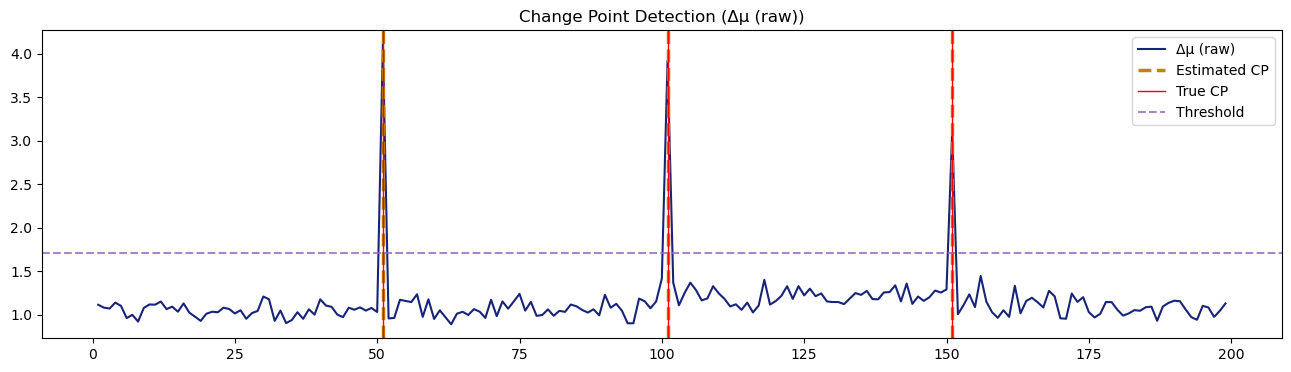

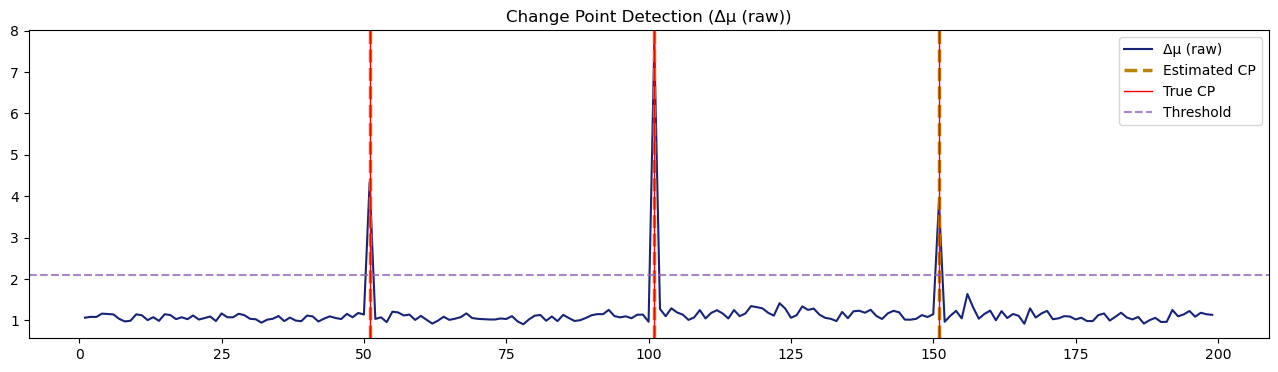

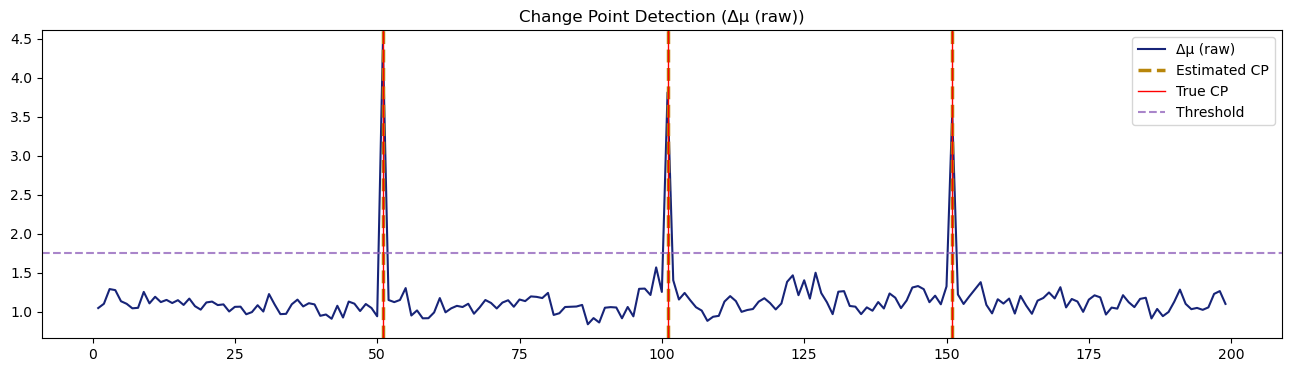

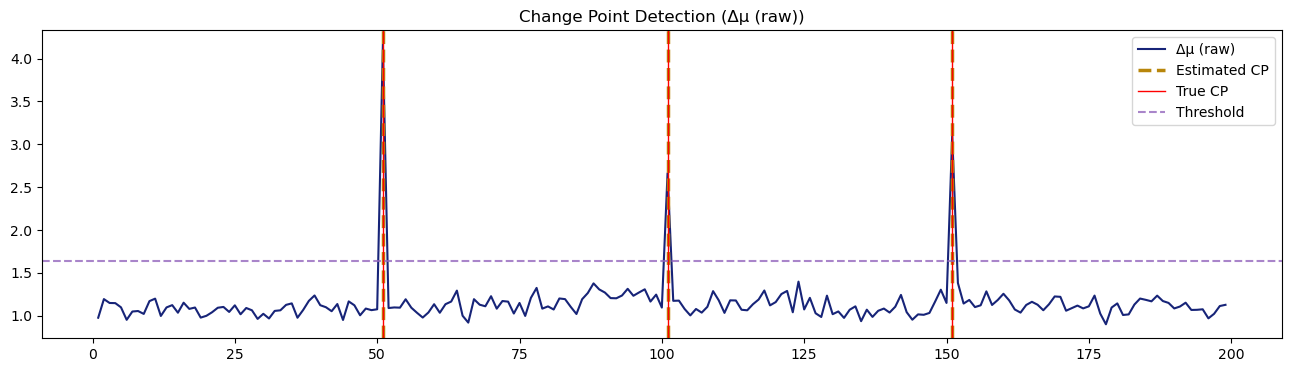

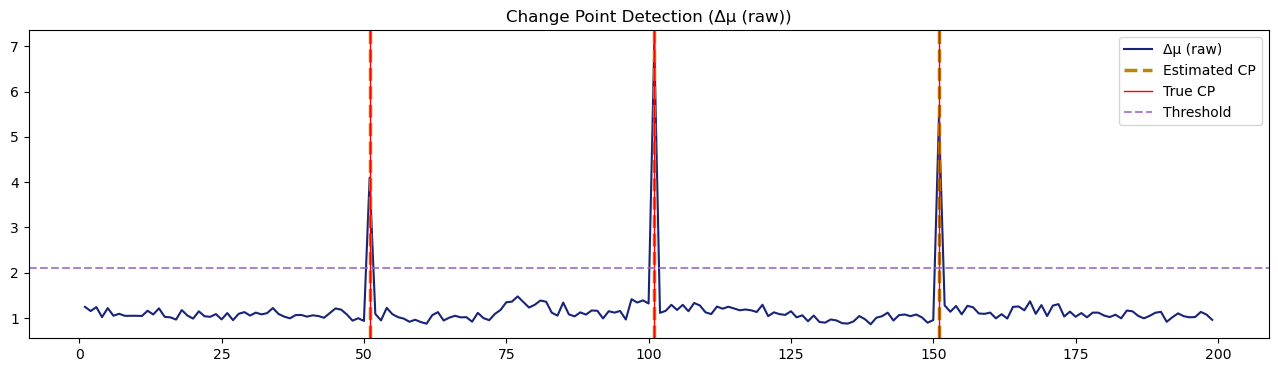

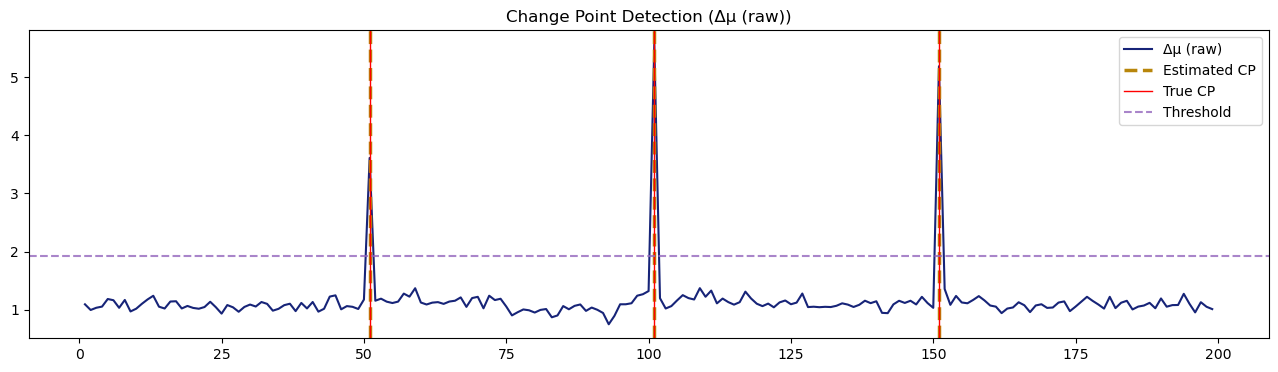

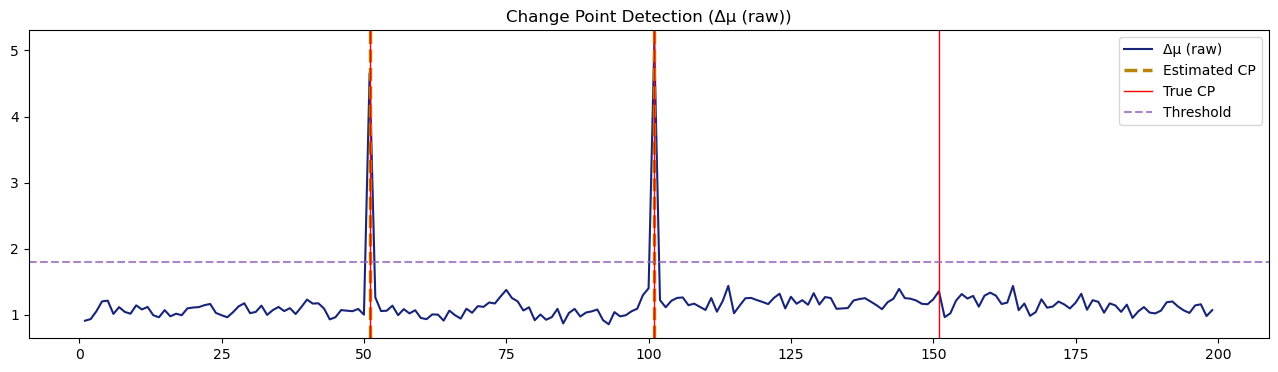

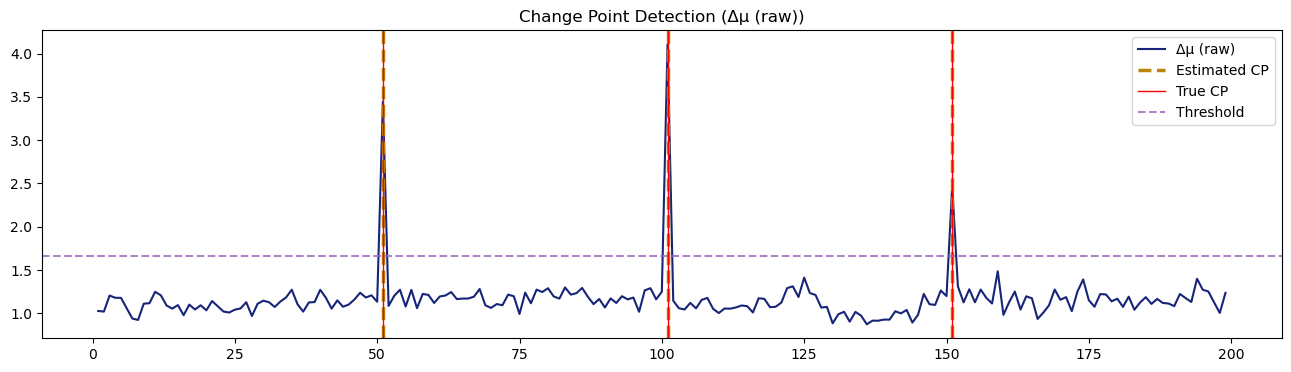

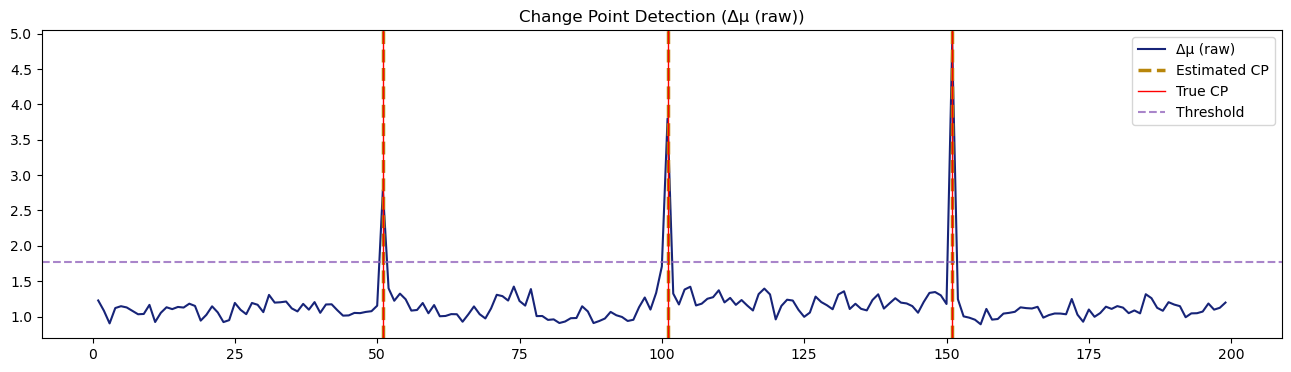

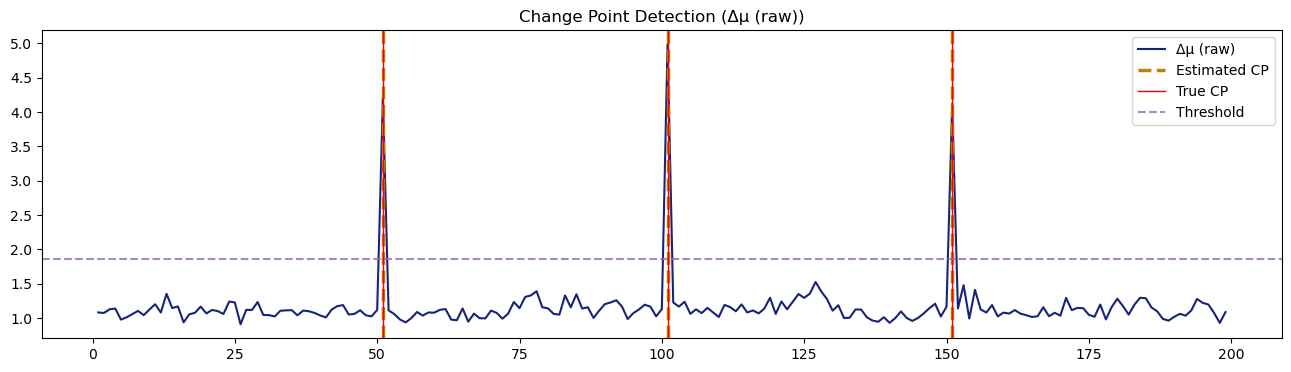

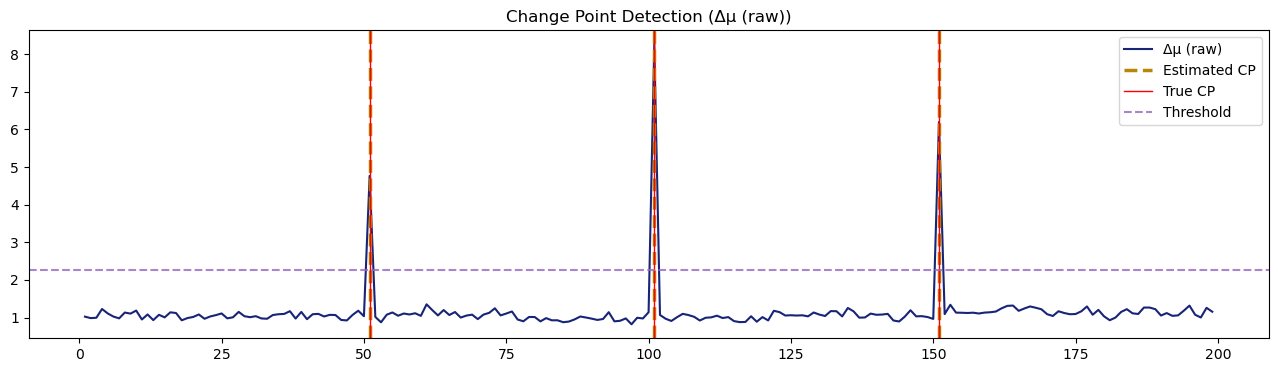

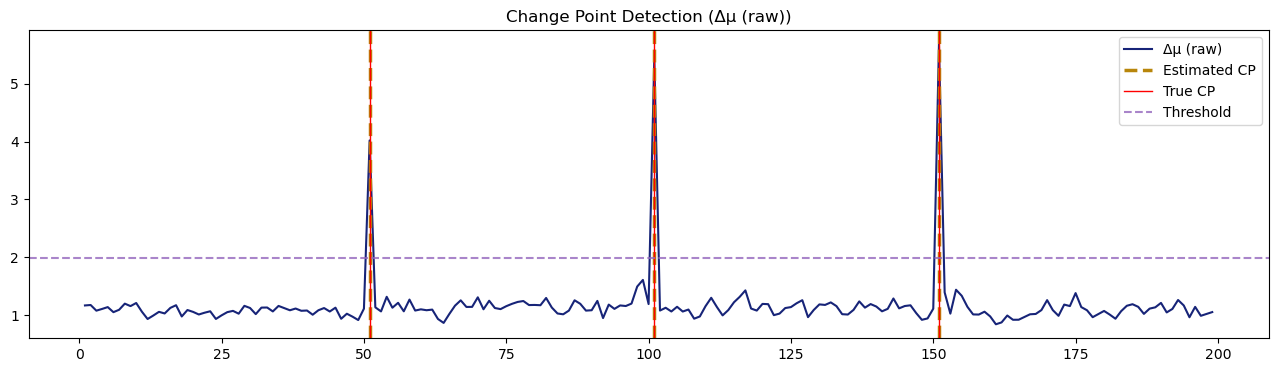

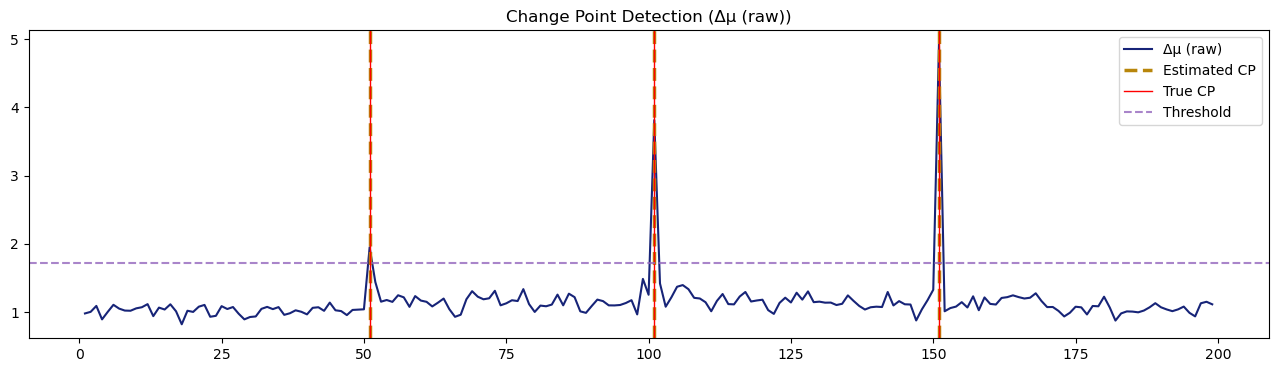

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

import torch
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from cpd_model import parse_args, evaluation, learn_one_seq_penalty, CPD, mixture_of_gaussians_loss
from data_generator import generate_x, generate_gmm_data_segments, softmax
import io, sys, warnings
warnings.filterwarnings("ignore", message="Deterministic behavior was enabled")

# =============================
# 0. Deterministic setup
# =============================
def set_global_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

# =============================
# 1. Segment functions
# =============================
mean_funcs_seg1 = [
    lambda x: np.array([x[0], x[1], x[2]]),
    lambda x: np.array([np.sin(x[0]), np.cos(x[1]), np.tanh(x[2])]),
    lambda x: np.array([x[0]**2, -x[1], 0.5*x[2]])
]
weight_func_seg1 = lambda x: softmax([x[0], -x[1], 0.3*x[2]])

mean_funcs_seg2 = [
    lambda x: np.array([4 + 2*x[0] + x[0]**2, 3*x[1] + 1, 2*x[2] + np.sin(2*x[0])]),
    lambda x: np.array([np.sin(2*x[0]) + 3, np.cos(2*x[1]) + 3, np.tanh(2*x[2])]),
    lambda x: np.array([x[0]**2 + 2, x[1] + 2, 1.5*x[2] + 2])
]
weight_func_seg2 = lambda x: softmax([-2*x[0] + 1, 2*x[1], np.sin(x[2])])

mean_funcs_seg3 = [
    lambda x: np.array([-5 - 3*x[0] + x[0]**2, -2*x[1], -1.5*x[2] + np.cos(3*x[0])]),
    lambda x: np.array([-2*np.sin(x[0]) - 4, -np.cos(x[1]) - 4, -np.tanh(x[2])]),
    lambda x: np.array([-x[0]**2 - 3, -x[1] - 3, -1.2*x[2] - 3])
]
weight_func_seg3 = lambda x: softmax([3*x[0], -2*x[1], np.cos(x[2])])

mean_funcs_seg4 = [
    lambda x: np.array([10 + 4*x[0] + 2*x[0]**2, 8*x[1] - 4, 6*x[2] + np.sin(4*x[0])]),
    lambda x: np.array([5*np.sin(3*x[0]) + 8, 5*np.cos(3*x[1]) + 8, 3*np.tanh(4*x[2])]),
    lambda x: np.array([6 - 2*x[0], 4*x[1]**2 + 3, 5*np.exp(-x[2]**2)])
]
weight_func_seg4 = lambda x: softmax([-4*x[0] + 3, 3*x[1] - 2, 5*np.sin(x[2])])

mean_funcs_list = [mean_funcs_seg1, mean_funcs_seg2, mean_funcs_seg3, mean_funcs_seg4]
weight_funcs_list = [weight_func_seg1, weight_func_seg2, weight_func_seg3, weight_func_seg4]

# =============================
# 2. Args setup
# =============================
args = parse_args()
args.epoch = 40
args.z_dim = 5
args.x_dim = 3
args.y_dim = 3
args.decoder_lr = 0.0001
args.decoder_iteration = 100
args.langevin_s = 0.1
args.langevin_K = 100
args.kappa = 0.2
args.penalties = [0.01, 0.1, 0.5, 1, 5, 10]
args.nu_iteration = 50
args.output_layer = [200, 200]
args.scale_y = False
args.scale_delta = False
args.signif_level = 0.95
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# =============================
# 3. Main loop
# =============================
os.makedirs("reps_sim_dat", exist_ok=True)
all_results = []

for rep_id in range(20): 
    print(f"\n==============================")
    print(f" Running replicate {rep_id}")
    print(f"==============================")
    set_global_seed(rep_id)

    # ---------- Data Generation ----------
    X = generate_x(T=args.num_time, N=args.num_samples, dx=args.x_dim)
    X, Y, comp_labels = generate_gmm_data_segments(
        X, mean_funcs_list, weight_funcs_list,
        change_points=[51, 101, 151],
        K=3, dy=args.y_dim
    )

    # ---------- Save the Data ----------
    np.savetxt(f"reps_sim_dat/x_rep{rep_id}.csv", X.reshape(-1, args.x_dim), delimiter=",")
    np.savetxt(f"reps_sim_dat/y_rep{rep_id}.csv", Y.reshape(-1, args.y_dim), delimiter=",")
    np.savetxt(f"reps_sim_dat/comp_labels_rep{rep_id}.csv", comp_labels, fmt="%d", delimiter=",")
    print(f"[INFO] Data saved for rep {rep_id}")

    # ---------- Standadize ----------
    X_flat = X.reshape(-1, args.x_dim)
    X_mean, X_std = X_flat.mean(axis=0, keepdims=True), X_flat.std(axis=0, keepdims=True) + 1e-8
    X_flat = (X_flat - X_mean) / X_std
    X_array = X_flat.reshape(args.num_time, -1, args.x_dim)

    x_input = torch.tensor(X_array, dtype=torch.float32).to(device)
    y_input = torch.tensor(Y.reshape(args.num_time, -1, args.y_dim), dtype=torch.float32).to(device)
    odd_idx, even_idx = range(1, args.num_time, 2), range(0, args.num_time, 2)
    x_train, x_test = x_input[odd_idx].reshape(-1, args.x_dim), x_input[even_idx].reshape(-1, args.x_dim)
    y_train, y_test = y_input[odd_idx].reshape(-1, args.y_dim), y_input[even_idx].reshape(-1, args.y_dim)

    results_half = []
    for penalty in args.penalties:
        _stdout = sys.stdout
        sys.stdout = io.StringIO()
        try:
            loss, pen = learn_one_seq_penalty(args, x_train, y_train, x_test, y_test, penalty=penalty, half=True)
        finally:
            sys.stdout = _stdout
        results_half.append([loss, pen])

    results_half = np.array(results_half)
    best_idx = np.argmin(results_half[:, 0])
    best_penalty = args.penalties[best_idx]
    print(f"[INFO] rep={rep_id}, best_penalty={best_penalty}")

    set_global_seed(rep_id)

    model = CPD(args, half=False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.decoder_lr)
    T, m, d, kappa = args.num_time, args.num_samples, args.z_dim, args.kappa
    mu, nu, w = torch.zeros(T, d, device=device), torch.zeros(T, d, device=device), torch.zeros(T, d, device=device)
    burn_in, delta_mu_list = 20, []

    for e in range(args.epoch):
        mu_repeat = mu.repeat_interleave(m, dim=0)
        z = torch.randn(T * m, d, device=device, requires_grad=True)
        for _ in range(args.langevin_K):
            pi, mean, sigma = model(x_input.reshape(T * m, args.x_dim), z)
            nll = mixture_of_gaussians_loss(y_input.reshape(T * m, args.y_dim), pi, mean, sigma)
            z_grad = torch.autograd.grad(nll, z)[0]
            z = z - args.langevin_s * z_grad + torch.sqrt(torch.tensor(2.0 * args.langevin_s, device=device)) * torch.randn_like(z)
        z = z.detach()
        expected_z = z.reshape(T, m, d).mean(dim=1)
        mu = (expected_z + kappa * (nu - w)) / (1.0 + kappa)
        mu = mu.detach()
        optimizer.zero_grad()
        pi, mean, sigma = model(x_input.reshape(T * m, args.x_dim), z)
        loss = mixture_of_gaussians_loss(y_input.reshape(T * m, args.y_dim), pi, mean, sigma) / m
        loss.backward()
        optimizer.step()
        if e + 1 > burn_in:
            delta_mu_list.append(torch.norm(torch.diff(mu, dim=0), p=2, dim=1).cpu().numpy())

    avg_delta = np.mean(delta_mu_list, axis=0)
    res = evaluation(avg_delta, args)
    print(f"[RESULT] rep={rep_id} | Detected CPs={res[5]} | Covering={res[3]:.4f}")

    all_results.append({
        "rep_id": rep_id,
        "best_penalty": best_penalty,
        "covering_metric": res[3],
        "detected_CPs": res[5],
        "abs_error": res[0],
        "dist_est_gt": res[1],
        "dist_gt_est": res[2],
    })

    del model, x_input, y_input
    torch.cuda.empty_cache()

# =============================
# Save Results
# =============================
df_results = pd.DataFrame(all_results)
print("\n=== Summary across all replicates ===")
print(df_results)
print("\nAverage covering metric:", df_results["covering_metric"].mean())
df_results.to_csv("cpd_replicate_results.csv", index=False)
